#  Université Paris Dauphine - PSL
- Master 2 IASD en apprentissage (2022-2023)
- Module : Become a Kaggle Master HW1
- Authors :
    - YBEGGAZENE Zakaria
    - AYARI Aziz

In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score
import warnings
from sklearn.metrics import mean_squared_error
warnings.filterwarnings('ignore')
%matplotlib inline

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [4]:
import matplotlib

from scipy.stats import skew
from scipy.stats.stats import pearsonr

%config InlineBackend.figure_format = 'retina' #set 'png' here when working on notebook

# Load the data

In [5]:
train = pd.read_csv("hw1_train.csv")
test = pd.read_csv("hw1_train.csv")

# Exploratory Data Analysis

In [6]:
total = train.isnull().sum().sort_values(ascending=False)
percent = (train.isnull().sum()/train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data_copy = missing_data.reset_index()

Data Visualization

In [8]:
fig = px.pie(missing_data_copy[:20], values='Percent', names='index', title='20 features with highest percentage of missing data')
fig.show()

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

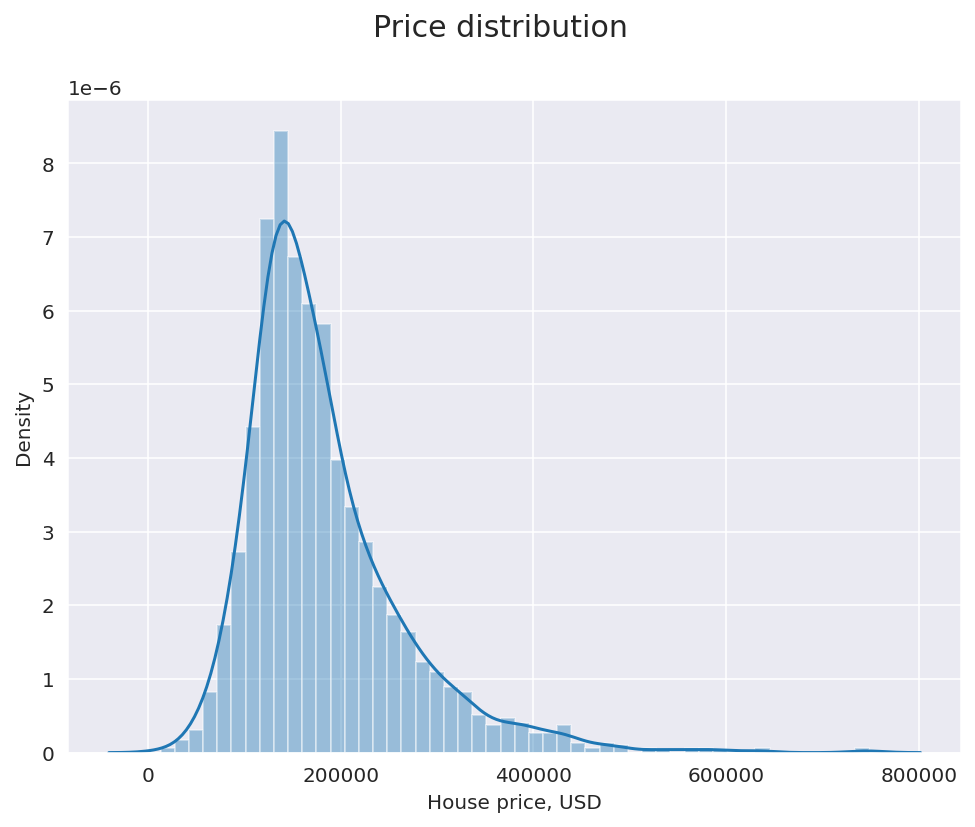

In [68]:
sns.set_style('darkgrid')

fig,ax = plt.subplots(1,1,figsize=(8,6))
sns.distplot(train['SalePrice'], ax=ax)

ax.set_xlabel('House price, USD')
plt.suptitle('Price distribution', size=15)
plt.show()

In [69]:
quantitative = [f for f in train.columns if train.dtypes[f] != 'object']
quantitative.remove('SalePrice')
quantitative.remove('Id')
qualitative = [f for f in train.columns if train.dtypes[f] == 'object']

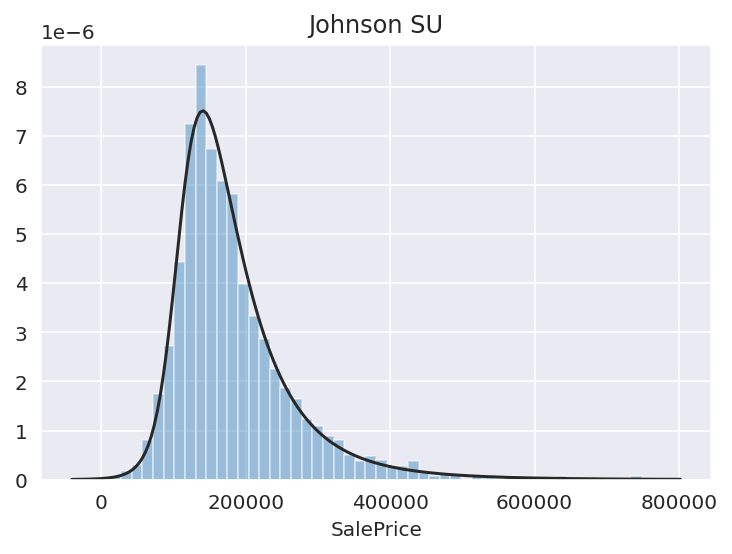

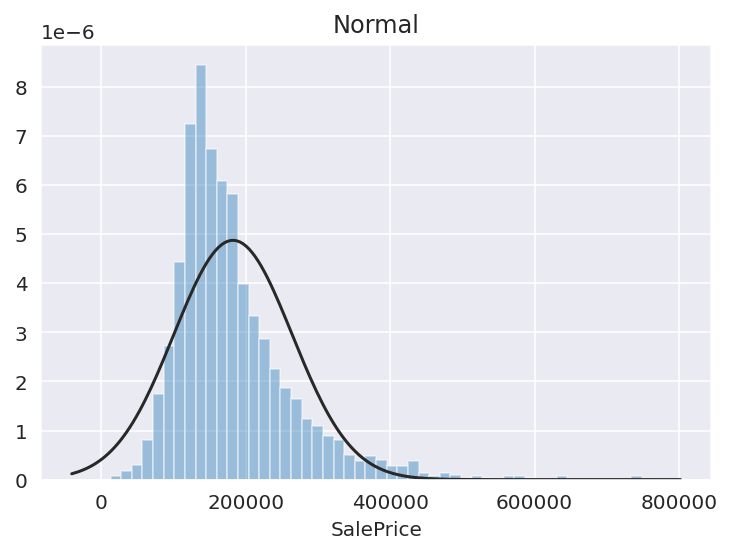

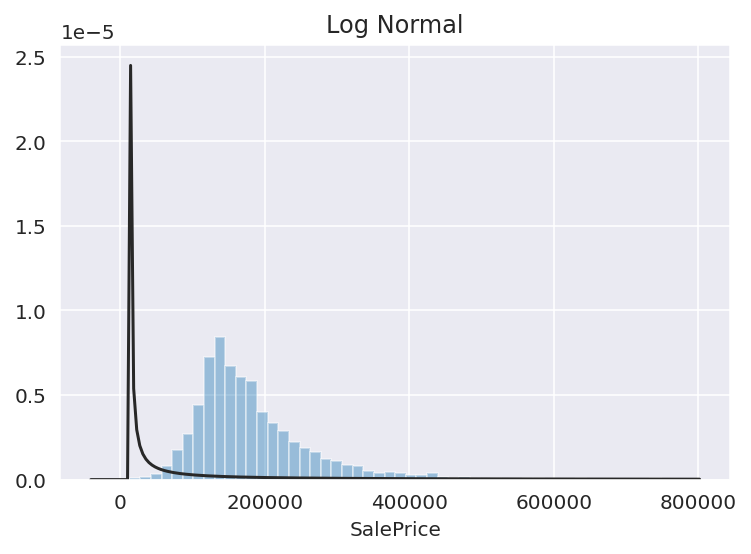

In [70]:
y = train['SalePrice']
plt.figure(1); 
plt.title('Johnson SU')
sns.distplot(y, kde=False, fit=stats.johnsonsu)
plt.figure(2); 
plt.title('Normal')
sns.distplot(y, kde=False, fit=stats.norm)
plt.figure(3); 
plt.title('Log Normal')
sns.distplot(y, kde=False, fit=stats.lognorm)

             SalePrice  Gr Liv Area
SalePrice     1.000000     0.702404
Gr Liv Area   0.702404     1.000000


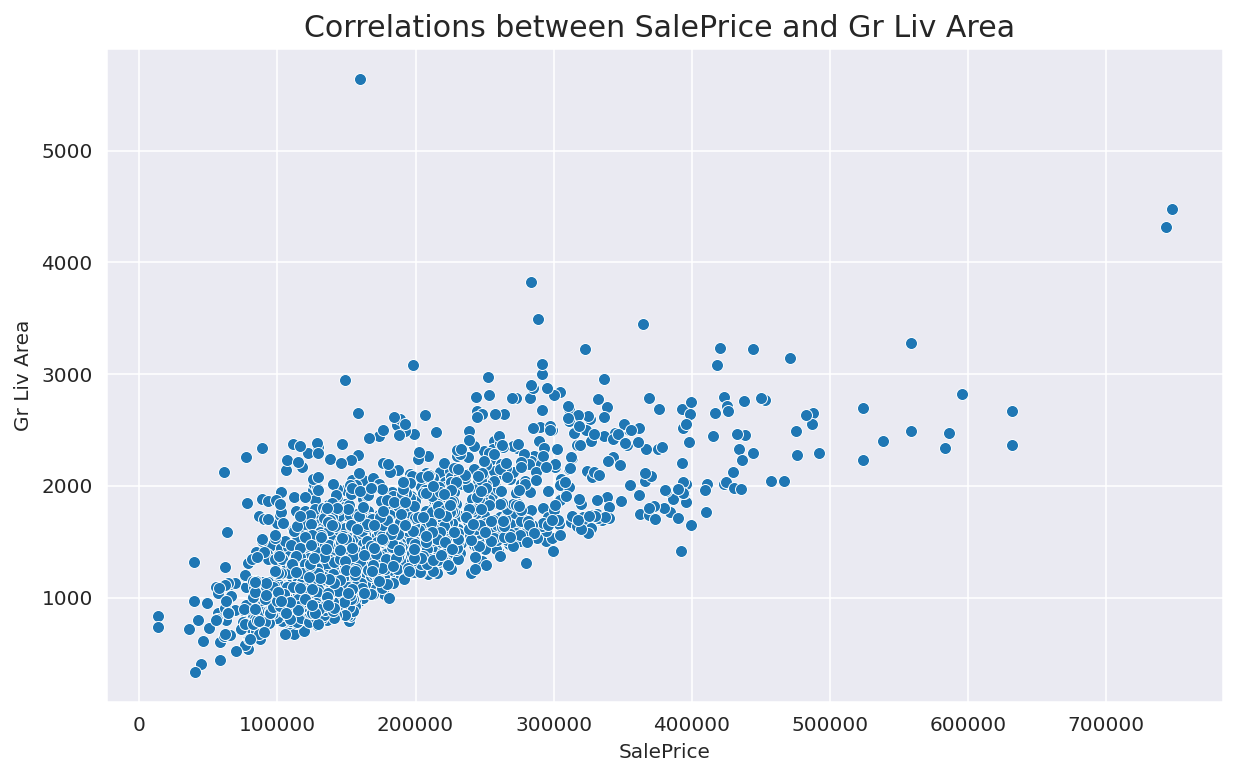

In [71]:
temp = train[['SalePrice','Gr Liv Area']]

plt.figure(figsize=(10,6))
sns.scatterplot(x=temp['SalePrice'], y=temp['Gr Liv Area'])
plt.title('Correlations between SalePrice and Gr Liv Area ', size=15);

print(temp.corr())

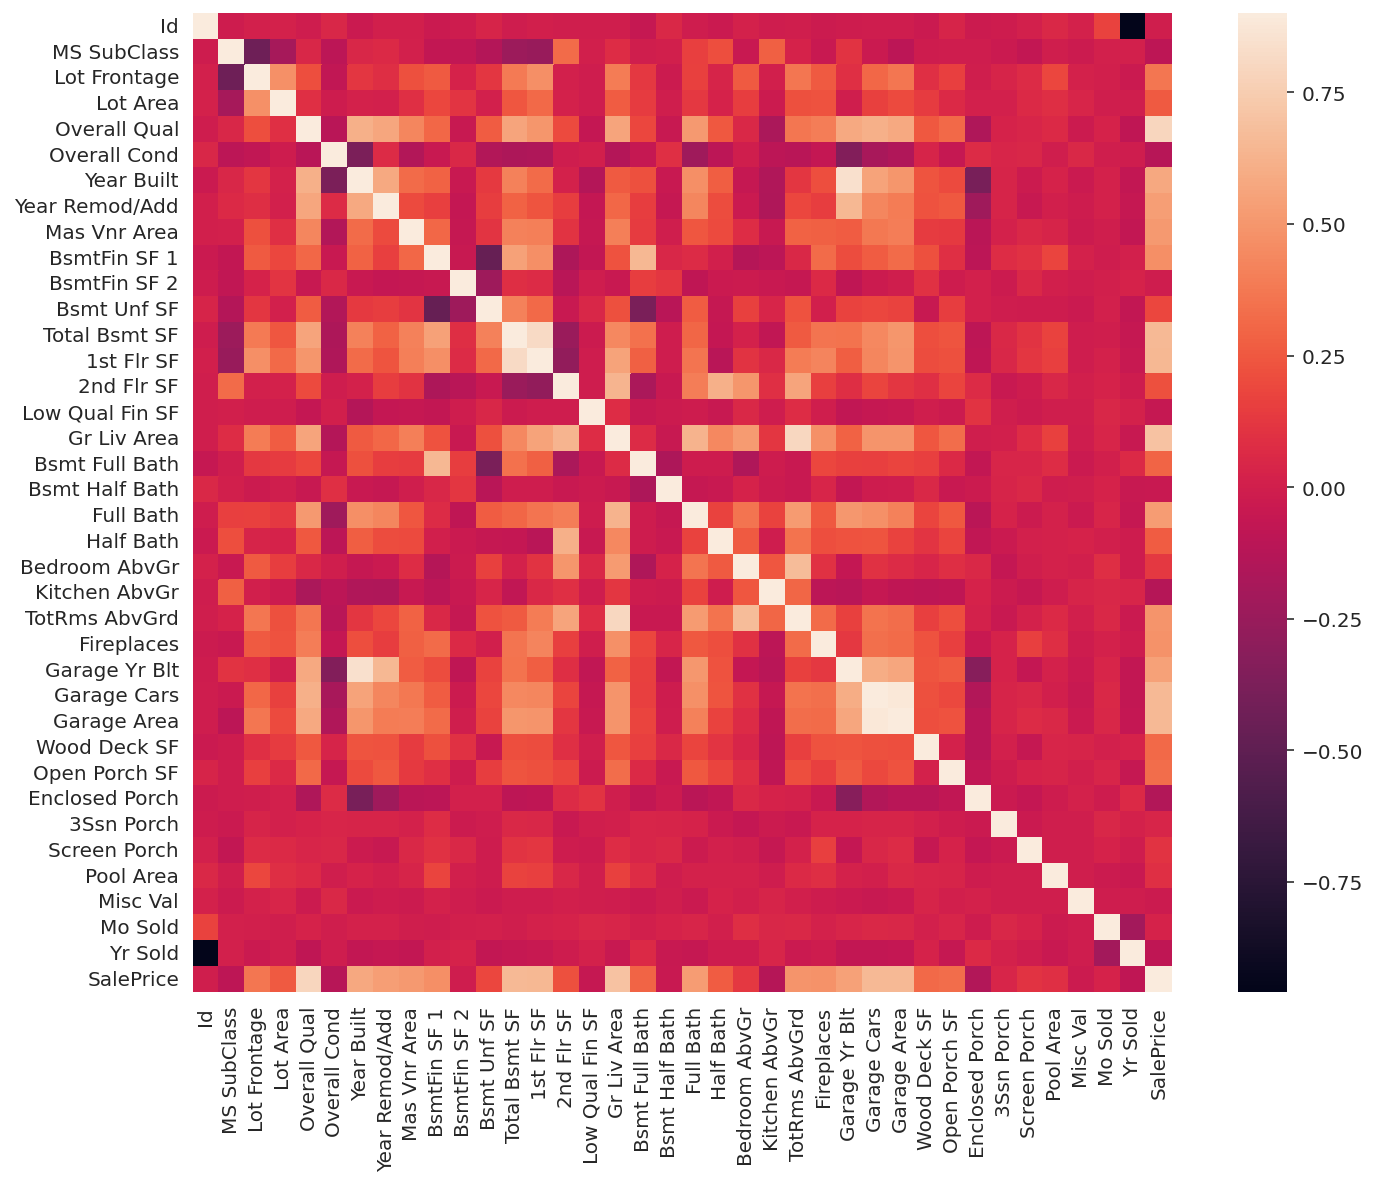

In [72]:
corrmat = train.corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=0.9, square=True)

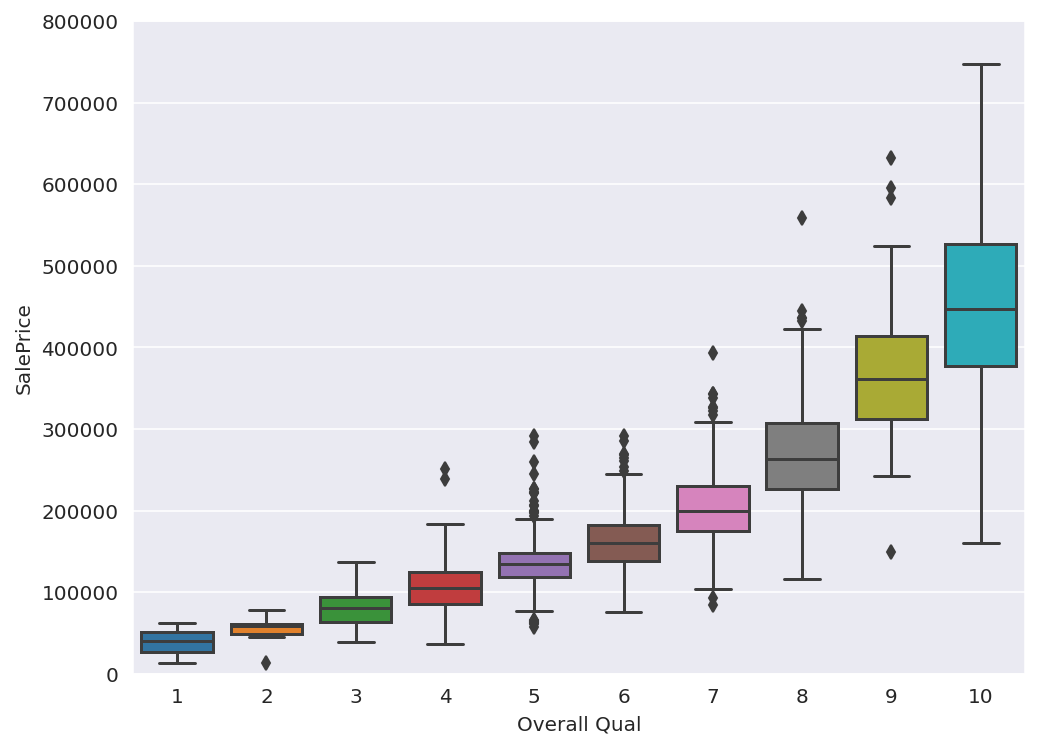

In [73]:
#box plot overallqual/saleprice
var= 'Overall Qual'
data = pd.concat([train['SalePrice'], train[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);

# Data Preprocessing

In [74]:
all_data = pd.concat((train.loc[:,'MS SubClass':'Sale Condition'],
                      test.loc[:,'MS SubClass':'Sale Condition']))

In [75]:
#log transform the target:
train["SalePrice"] = np.log1p(train["SalePrice"])

#log transform skewed numeric features:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

all_data[skewed_feats] = np.log1p(all_data[skewed_feats])

In [76]:
skewed_feats

Index(['MS SubClass', 'Lot Frontage', 'Lot Area', 'Mas Vnr Area',
       'BsmtFin SF 1', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF',
       '1st Flr SF', '2nd Flr SF', 'Low Qual Fin SF', 'Gr Liv Area',
       'Bsmt Half Bath', 'Kitchen AbvGr', 'Wood Deck SF', 'Open Porch SF',
       'Enclosed Porch', '3Ssn Porch', 'Screen Porch', 'Pool Area',
       'Misc Val'],
      dtype='object')

In [77]:
all_data = all_data.drop((missing_data[missing_data['Total'] > 1]).index,1)

In [78]:
all_data = pd.get_dummies(all_data)

In [79]:
#all_data = all_data[all_data.dtypes[all_data.dtypes != "object"].index]

In [80]:
#filling NA's with the mean of the column:
all_data = all_data.fillna(all_data.mean())

# Models

In [81]:
#creating matrices for sklearn:
X_train = all_data[:train.shape[0]]
X_test = all_data[train.shape[0]:]
y = train.SalePrice
data_train=X_train.copy()
data_test=X_test.copy()

In [82]:
def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

# Ridge Model

In [83]:
model_ridge = Ridge()

In [84]:
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean() 
            for alpha in alphas]

Text(0, 0.5, 'rmse')

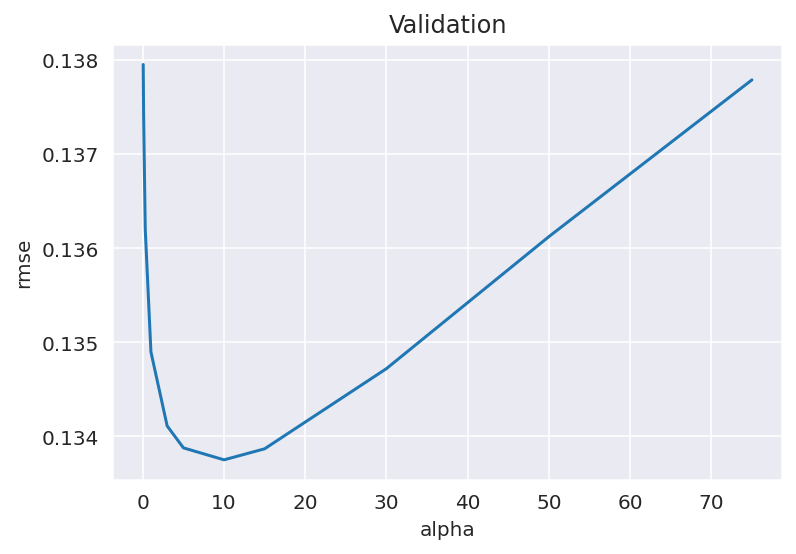

In [85]:
cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Validation")
plt.xlabel("alpha")
plt.ylabel("rmse")

In [86]:
cv_ridge.min()

0.13375113168467823

# Lasso MModel

In [87]:
model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005]).fit(X_train, y)

In [88]:
rmse_cv(model_lasso).mean()

0.13043904047705296

In [89]:
coef = pd.Series(model_lasso.coef_, index = X_train.columns)

In [90]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 86 variables and eliminated the other 136 variables


In [91]:
imp_coef = pd.concat([coef.sort_values().head(10),
                     coef.sort_values().tail(10)])

Text(0.5, 1.0, 'Coefficients in the Lasso Model')

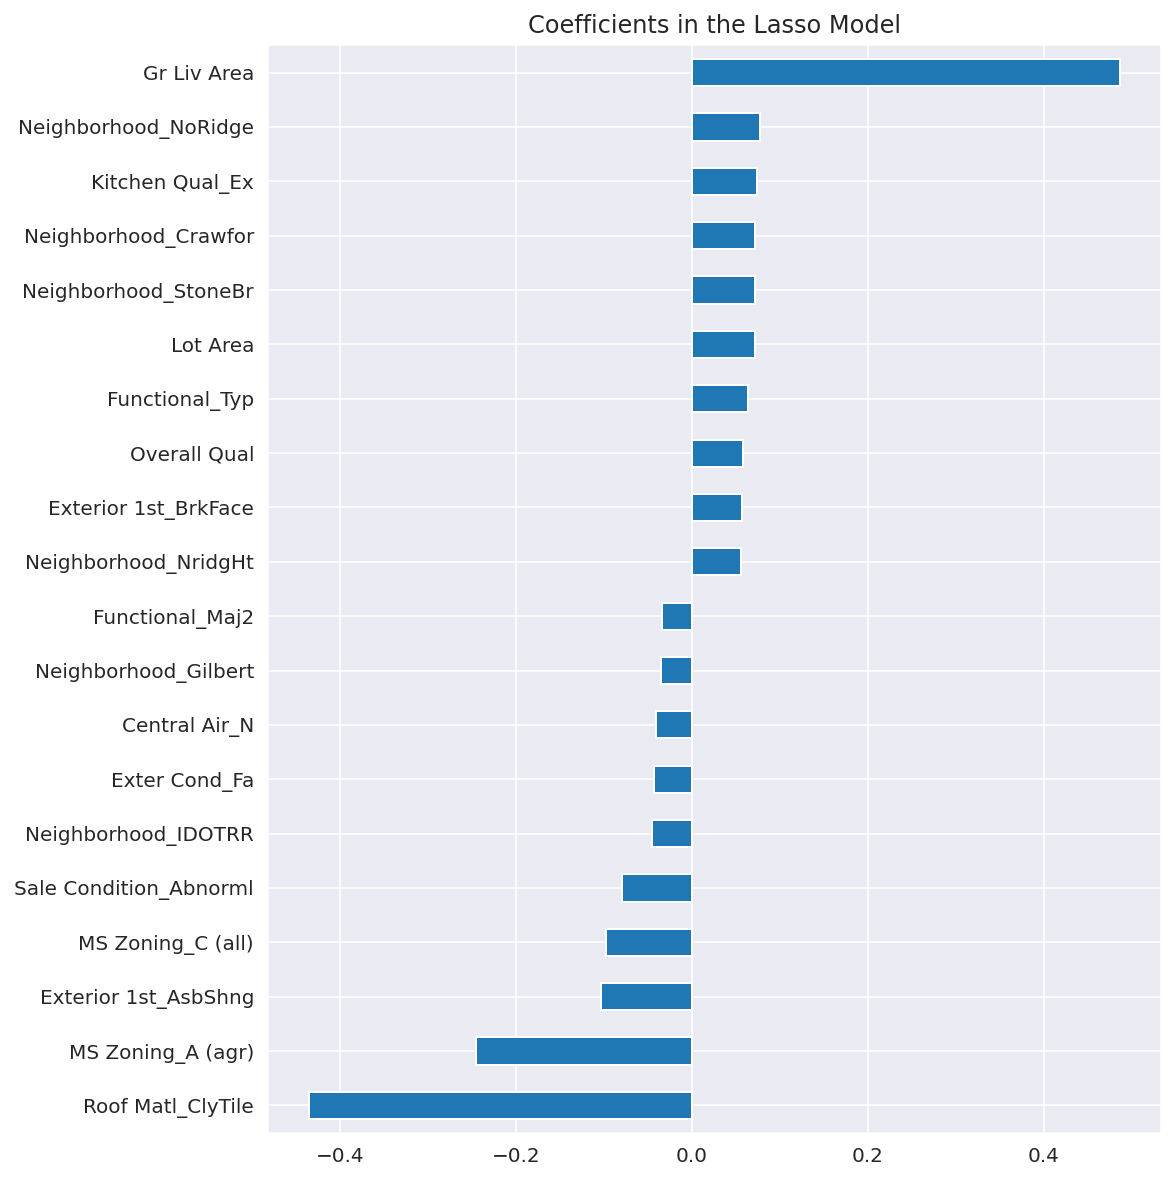

In [92]:
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")

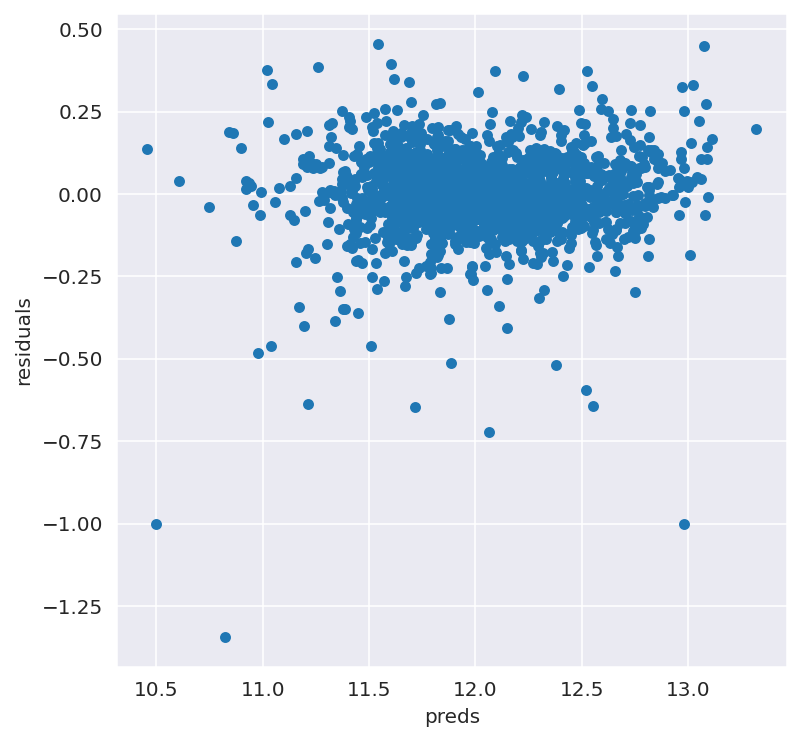

In [93]:
#let's look at the residuals as well:
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)

preds = pd.DataFrame({"preds": model_lasso.predict(X_train), "true": y})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter")

# Xgboost model

In [94]:
import xgboost as xgb

In [95]:
dtrain = xgb.DMatrix(X_train, label = y)
dtest = xgb.DMatrix(X_test)

params = {"max_depth":2, "eta":0.1}
model = xgb.cv(params, dtrain,  num_boost_round=500, early_stopping_rounds=100)

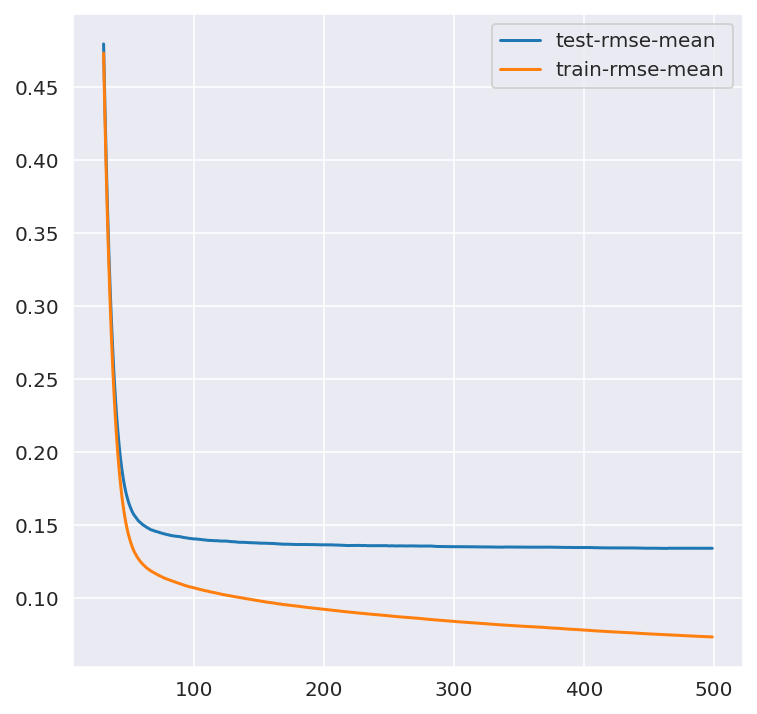

In [96]:
model.loc[30:,["test-rmse-mean", "train-rmse-mean"]].plot()

In [97]:
model_xgb = xgb.XGBRegressor(n_estimators=360, max_depth=2, learning_rate=0.1) #the params were tuned using xgb.cv
model_xgb.fit(X_train, y)

[21:42:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(max_depth=2, n_estimators=360)

In [98]:
xgb_preds = np.expm1(model_xgb.predict(X_test))
lasso_preds = np.expm1(model_lasso.predict(X_test))

In [99]:
xgb_preds_train = np.expm1(model_xgb.predict(X_train))
lasso_preds = np.expm1(model_lasso.predict(X_train))

In [100]:
y_exp=np.exp(y)
np.sqrt(mean_squared_error(y_exp, xgb_preds_train))

16007.528300754022

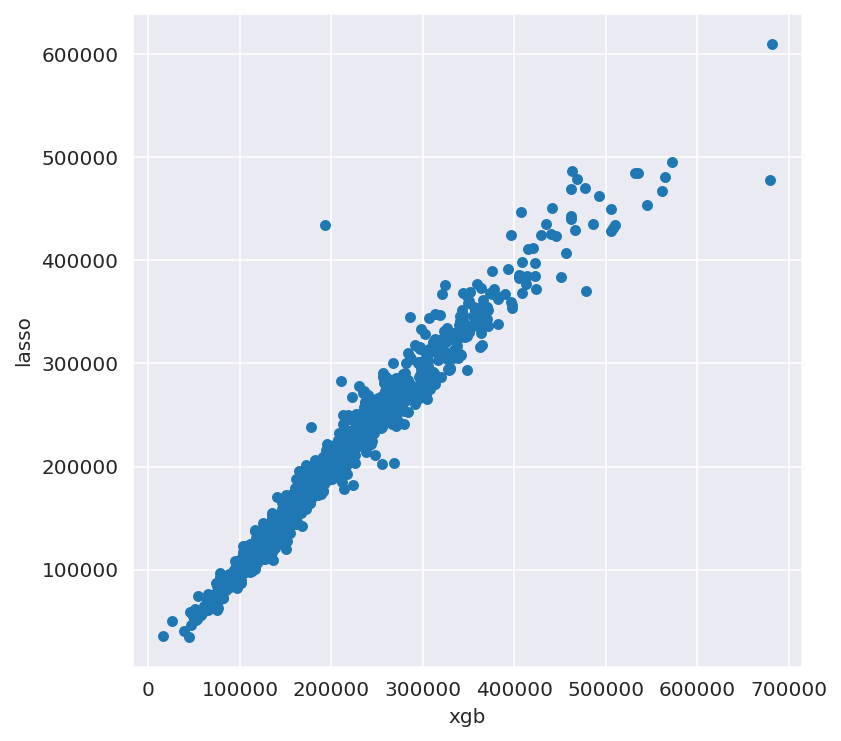

In [101]:
predictions = pd.DataFrame({"xgb": xgb_preds, "lasso": lasso_preds})
predictions.plot(x = "xgb", y = "lasso", kind = "scatter")

In [102]:
preds = 0.7*lasso_preds + 0.3*xgb_preds

In [103]:
solution = pd.DataFrame({"Id":test.Id, "Predicted":xgb_preds})
solution.to_csv("submission.csv", index = False)

In [104]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data_train, y, test_size=0.33, random_state=42)
y_test=np.exp(y_test)

#GradientBoostingRegressor




In [105]:
from sklearn.ensemble import GradientBoostingRegressor
reg = GradientBoostingRegressor(random_state=0)
reg.fit(X_train, y_train)
y_pred=np.exp(reg.predict(X_test))
np.sqrt(mean_squared_error(y_test, y_pred))

29130.936928942032

In [106]:
solution = pd.DataFrame({"Id":test.Id, "Predicted":xgb_preds})
solution.to_csv("submission.csv", index = False)

# K Fold

In [107]:
from sklearn.model_selection import KFold
X=data_train
y=y
# Define the number of folds (k)
k = 3
kf = KFold(n_splits=k)

# Initialize an array to store the mean squared errors
mse_values = []

# Loop through each fold
for train_index, test_index in kf.split(X):
    
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Fit the model on the training data
    reg.fit(X_train, y_train)
    
    # Predict the target values on the test data
    y_pred = reg.predict(X_test)
    
    # Calculate the mean squared error between the actual and predicted values
    mse = np.sqrt(mean_squared_error(np.exp(y_test),np.exp(y_pred)))
    
    # Add the mean squared error to the mse_values array
    mse_values.append(mse)

# Calculate the mean of the mean squared errors
mean_mse = np.mean(mse_values)
print("The mean_mse is :",mean_mse)

The mean_mse is : 26086.200498395076


# Adaboost

In [108]:
from sklearn.ensemble import AdaBoostRegressor
regr = AdaBoostRegressor(random_state=0, n_estimators=100)
regr.fit(X_train, y_train)
pred_Adaboost=regr.predict(X_test)
np.sqrt(mean_squared_error(y_test,np.exp(pred_Adaboost)))

183849.48732796084

# Artificial Neural Network

In [109]:
# Importing the Keras libraries and packages
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LeakyReLU,PReLU,ELU
from keras.layers import Dropout

from keras import backend as K
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))


# Initialising the ANN
classifier = Sequential()

# Adding the input layer and the first hidden layer
classifier.add(Dense(50,activation='relu',input_dim = 222))

# Adding the second hidden layer
classifier.add(Dense(25,activation='relu'))

# Adding the third hidden layer
classifier.add(Dense(50,activation='relu'))
# Adding the output layer
classifier.add(Dense(1))

# Compiling the ANN
classifier.compile(loss=root_mean_squared_error, optimizer='Adamax')

# Fitting the ANN to the Training set
model_history=classifier.fit(X_train.values, y_train.values,validation_split=0.20, batch_size = 10,epochs =100)

Epoch 1/200
107/107 [==============================] - 1s 4ms/step - loss: 5.8847 - val_loss: 0.5014
Epoch 2/200
107/107 [==============================] - 0s 3ms/step - loss: 0.8197 - val_loss: 0.5231
Epoch 3/200
107/107 [==============================] - 0s 3ms/step - loss: 0.6477 - val_loss: 0.5318
Epoch 4/200
107/107 [==============================] - 0s 3ms/step - loss: 0.6205 - val_loss: 1.1640
Epoch 5/200
107/107 [==============================] - 0s 3ms/step - loss: 0.7822 - val_loss: 0.2379
Epoch 6/200
107/107 [==============================] - 0s 3ms/step - loss: 0.8399 - val_loss: 0.5610
Epoch 7/200
107/107 [==============================] - 0s 3ms/step - loss: 0.6590 - val_loss: 0.7976
Epoch 8/200
107/107 [==============================] - 0s 3ms/step - loss: 0.6211 - val_loss: 1.0788
Epoch 9/200
107/107 [==============================] - 0s 3ms/step - loss: 0.7674 - val_loss: 0.8732
Epoch 10/200
107/107 [==============================] - 0s 3ms/step - loss: 0.6352 - val_lo

In [110]:
ann_pred=classifier.predict(X_test.values)

21/21 [==============================] - 0s 2ms/step


In [111]:
pred_test=np.exp(ann_pred).flatten()
np.sqrt(mean_squared_error(y_test, pred_test))

206083.7226955515

In [114]:
ann_pred_test=classifier.predict(data_test.values)
pred_test=np.exp(ann_pred_test).flatten()

63/63 [==============================] - 0s 2ms/step


In [115]:
solution = pd.DataFrame({"Id":test.Id, "Predicted":pred_test})
solution.to_csv("submission.csv", index = False)